In [ ]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
script_dir = os.getcwd()
data_folder_path = os.path.join(script_dir, "optimization_results")

def plot_fidelity(vary_param, fixed_value, V, J_V_final):
    fig, ax = plt.subplots()
    
    colors = {2: "red", 3: "blue", 4: "green", 5: "black"}
    markers = {2: "o", 3: "s", 4: "^", 5: "D"}
    
    vary_values = [2, 3, 4, 5]
    Ts = list(range(1, 11))
    
    for value in vary_values:
        if vary_param == "N":
            N, M = value, fixed_value
        elif vary_param == "M":
            N, M = fixed_value, value
        else:
            raise ValueError("vary_param must be either 'N' or 'M'")
        
        color = colors[value]
        marker = markers[value]
        ground_state_fidelities = []
        
        for T in Ts:
            csv_filename = f"N={N}_M={M}_V={V}_JVfinal={J_V_final}_T={T}.csv"
            csv_path = os.path.join(data_folder_path, csv_filename)

            if not os.path.exists(csv_path):
                #print(f"Warning: {csv_path} not found, skipping...")
                continue
            
            df = pd.read_csv(csv_path)
            J_V_path = np.array(df["J_V_path"])
            mu_V_path = np.array(df["mu_V_path"])
            times_dense = np.array(df["times_dense"])

            hamiltonians = [
                construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i])
                for i in range(len(times_dense))
            ]
            
            results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
            #plot_time_evolution(N, M, results, times_dense, J_V_ratios=J_V_path, mu_V_ratios=mu_V_path, plot_overlaps = False, plot_sigma = False)
            ground_state_fidelities.append(results[2][-1][0])
        
        if ground_state_fidelities:
            ax.plot(Ts[:len(ground_state_fidelities)], ground_state_fidelities, marker=marker, color=color, 
                    label=f"Calculated Fidelities ({vary_param}={value})")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(f"Ground State Fidelity: {('M' if vary_param == 'N' else 'N')} = {fixed_value}, $V = {V}$, $(J/V)_f = {J_V_final}$")
    ax.set_xlabel("Total Evolution Time $T$ [$1/|V|$]")
    ax.set_ylabel("Ground State Fidelity")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
    ax.grid()
    fig.tight_layout()
    plt.show()


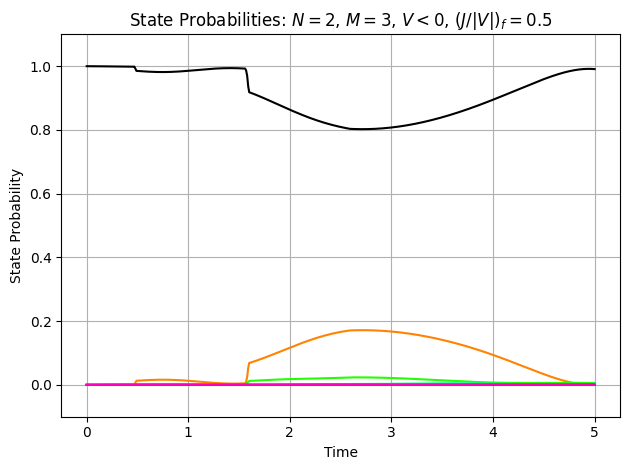

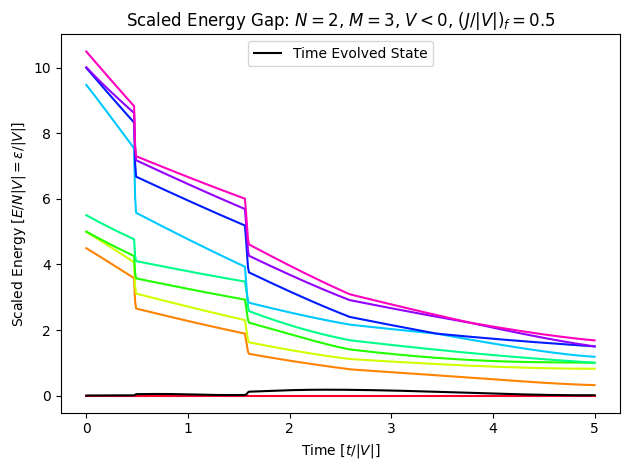

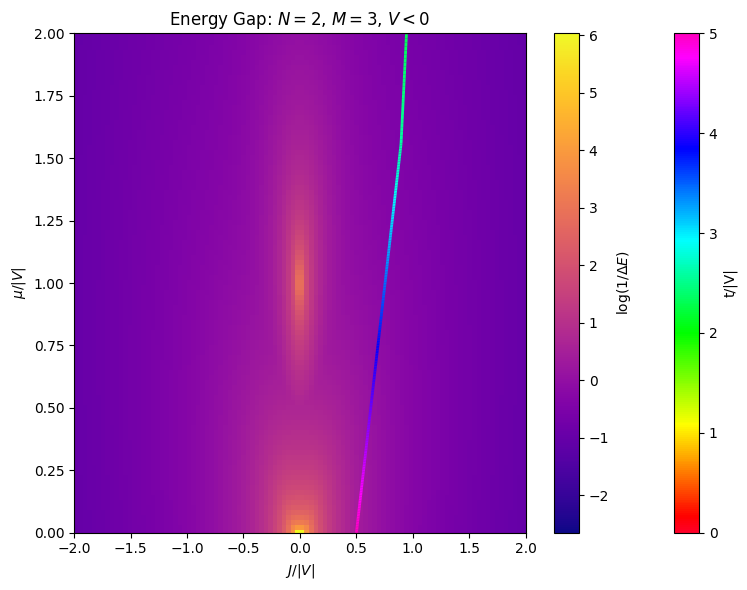

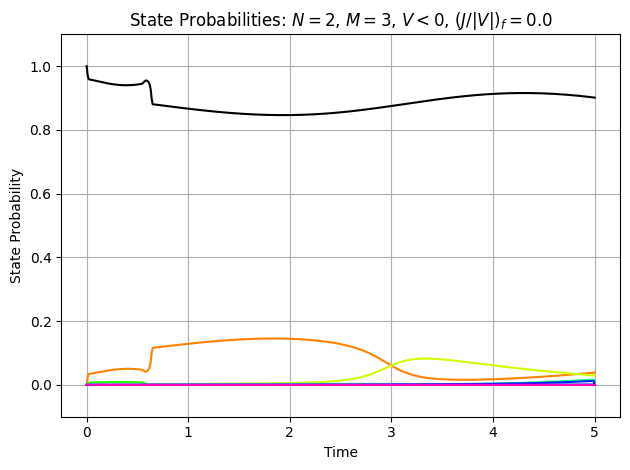

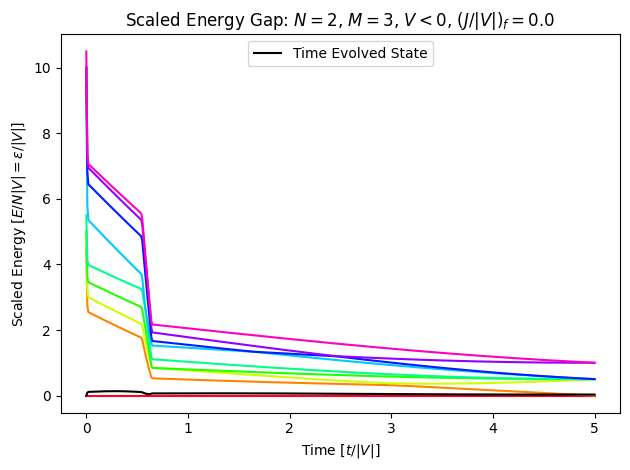

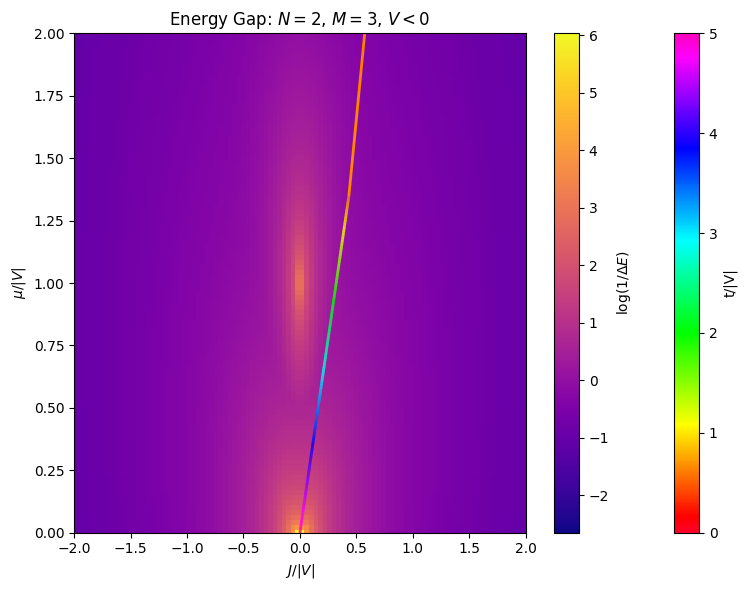

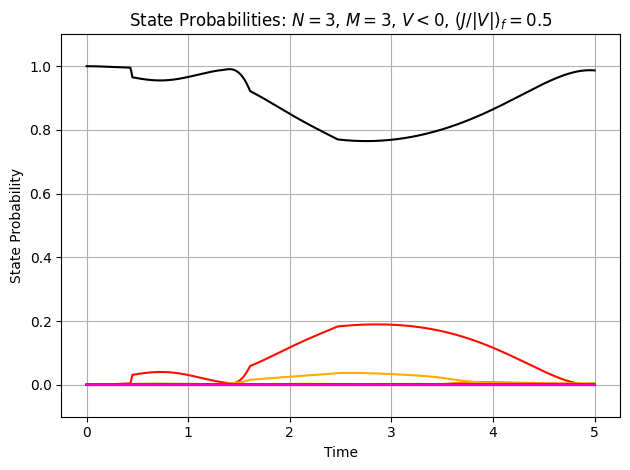

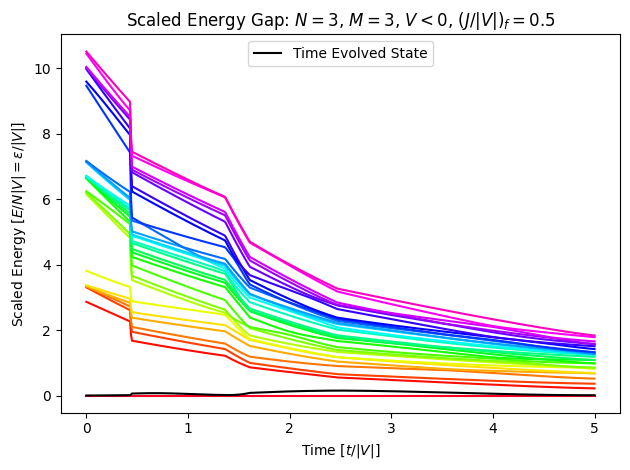

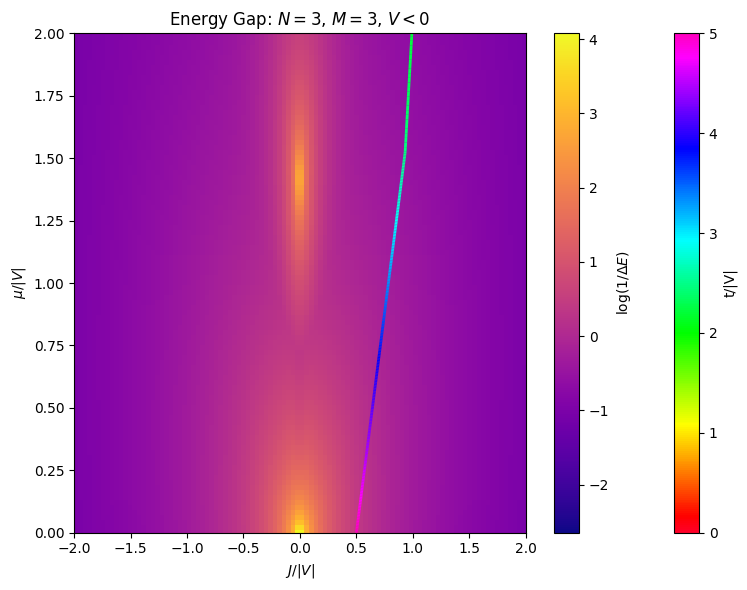

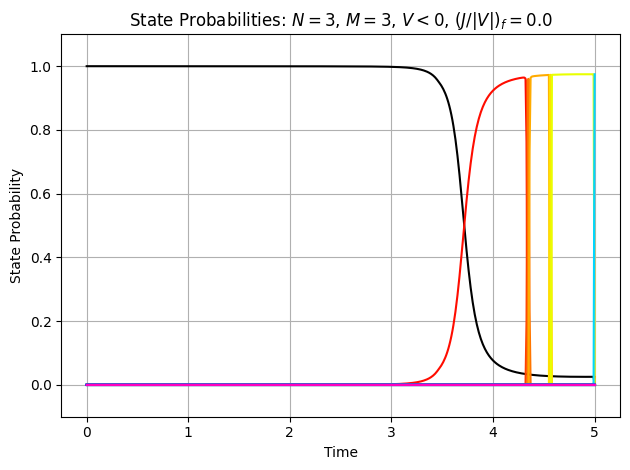

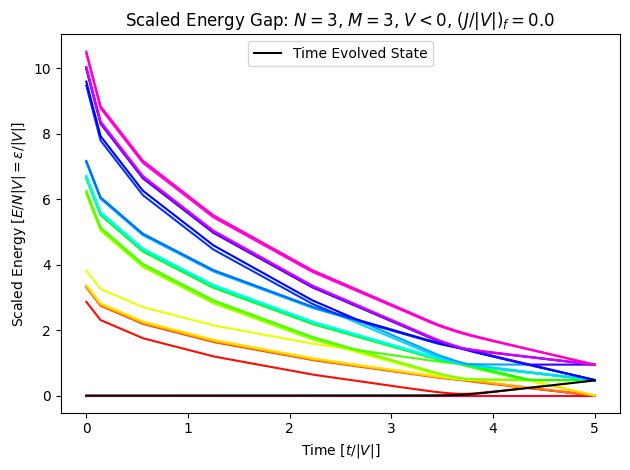

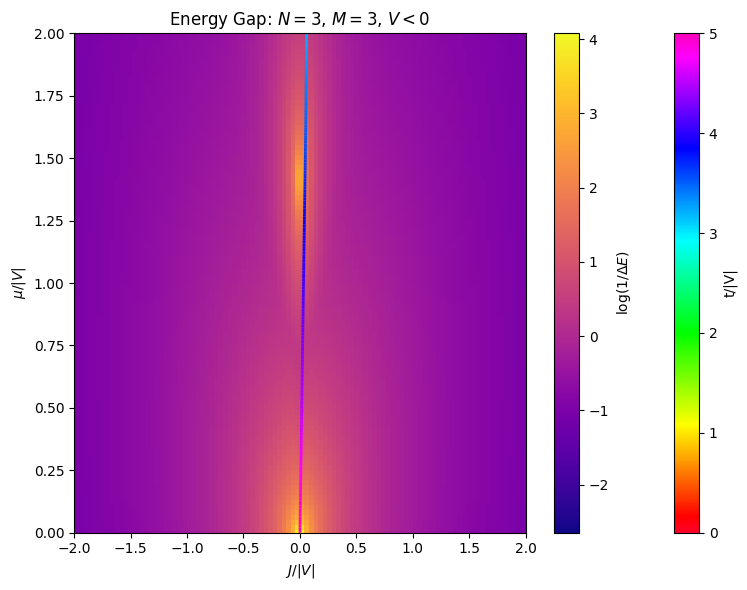

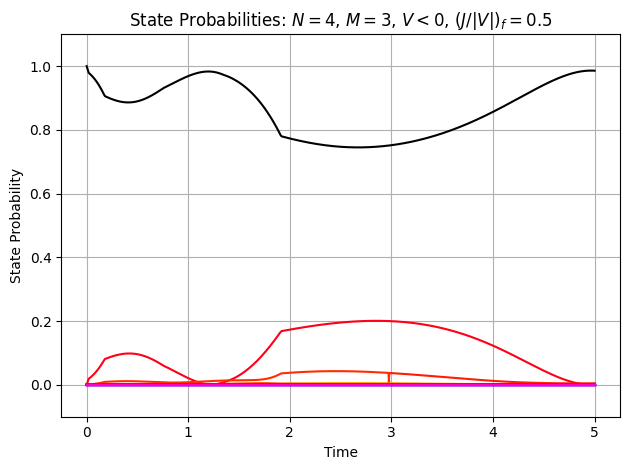

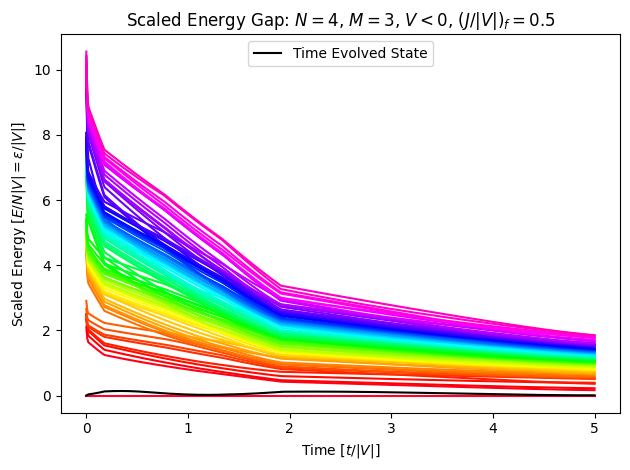

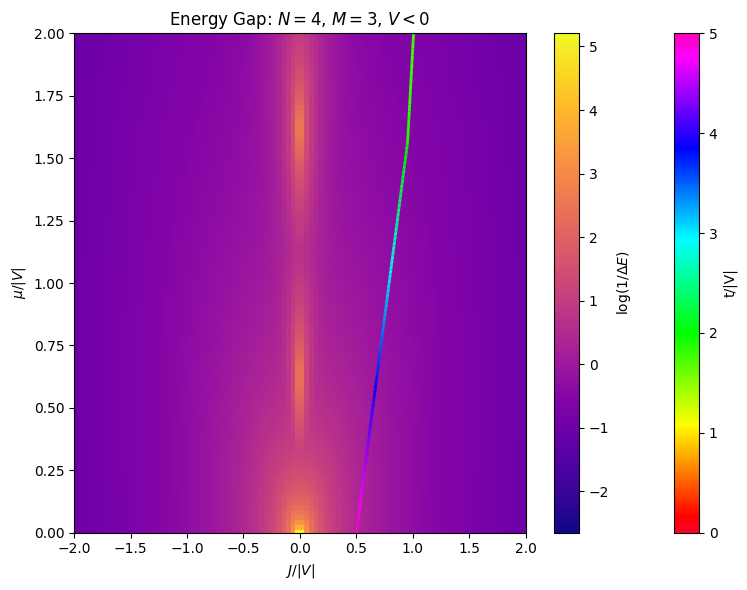

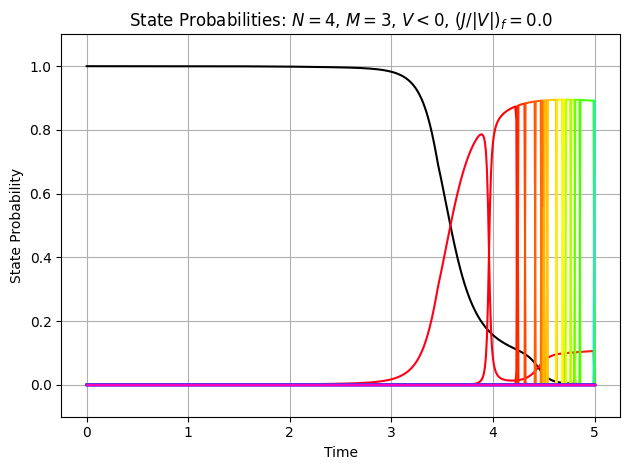

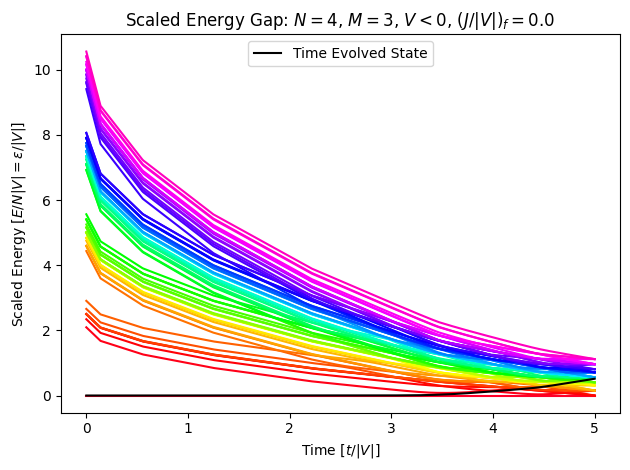

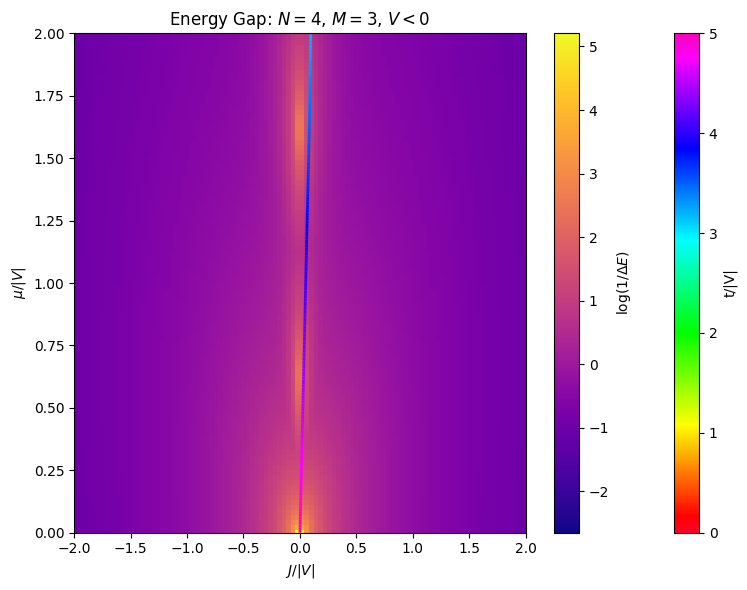

In [3]:
M = 3
Ns = [2,3,4]
V = -1

T = 5
J_V_finals = [0.5,0]

for N in Ns:
    for J_V_final in J_V_finals:
        csv_filename = f"N={N}_M={M}_V={V}_JVfinal={J_V_final}_T={T}.csv"
        csv_filename = f"N={N}_M={M}_V={V}_JVfinal={J_V_final}_T={T}.csv"
        csv_path = os.path.join(data_folder_path, csv_filename)
        if not os.path.exists(csv_path):
            #print(f"Warning: {csv_path} not found, skipping...")
            continue
        
        df = pd.read_csv(csv_path)
        J_V_path = np.array(df["J_V_path"])
        mu_V_path = np.array(df["mu_V_path"])
        times_dense = np.array(df["times_dense"])
        
        hamiltonians = [construct_rescaled_hamiltonian(N, M, V, mu_V_ratio=mu_V_path[i], J_V_ratio=J_V_path[i]) for i in range(len(times_dense))]
        results = simulate_hamiltonian_time_evolution(hamiltonians, times_dense)
        plot_time_evolution(N, M, results, times_dense, J_V_ratios=J_V_path, mu_V_ratios=mu_V_path, plot_overlaps = False, plot_sigma = False)
        
        plot_data(N, M, sign_V="negative", gap_or_sigma="energy_gap", include_path=True, mu_V_ratios=mu_V_path, J_V_ratios=J_V_path, times=times_dense)

    
    